<a href="https://colab.research.google.com/github/takayuki1997/SVM/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM多項式カーネルを用いた学術テキストの分野分類
* 科研費データベースから概要テキストを入手
* テキストをベクトル化（TF-IDFでもできるがヒューリスティック。PMI (Pointwise Mutual Information)やNPMIや（SIF (Smooth Inverse Frequency)）を調査）
* SVMの実装にはscikit-learnライブラリを利用



# MeCabのインストール

In [1]:
# 30秒以下
!apt install mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3
!mv /etc/mecabrc /usr/local/etc/

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libmecab2 mecab-ipadic mecab-utils
The following NEW packages will be installed:
  libmecab-dev libmecab2 mecab mecab-ipadic mecab-ipadic-utf8 mecab-utils
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,367 kB of archives.
After this operation, 59.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab2 amd64 0.996-14build9 [199 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libmecab-dev amd64 0.996-14build9 [306 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-utils amd64 0.996-14build9 [4,850 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/main amd64 mecab-ipadic all 2.7.0-20070801+main-3 [6,718 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 mecab amd64 0.996-14build9 [136 kB]
Get:6 http://archive.ubuntu.co

# 学習データの読み込み　分かち書き

In [2]:
import pandas as pd
import MeCab

# MeCabの設定
tagger = MeCab.Tagger('-Owakati')

# CSVファイルの読み込み
input_csv = '/content/drive/MyDrive/NaiveBayes/kakenhi/kaken_bc.csv'
print(f'読み込み中: {input_csv}...')
df = pd.read_csv(input_csv, encoding='utf-8', usecols=['Category', 'Summary'])

print("元のデータの最初の3行:")
print(df.head(3))

# テキストの前処理関数
def preprocess_text(text):
    return ' '.join(tagger.parse(str(text)).split())

# データの前処理
df['Processed_Summary'] = df['Summary'].apply(preprocess_text)

# 不要なカラムの削除
processed_df = df.drop('Summary', axis=1)

# 結果の確認
print("\n処理後のデータの最初の3行:")
print(processed_df.head(3))
print(f"\n処理されたデータ数: {len(processed_df)}")

読み込み中: /content/drive/MyDrive/NaiveBayes/kakenhi/kaken_bc.csv...
元のデータの最初の3行:
  Category                                            Summary
0        A  自閉症の医学的研究は、近年、次々と新しい事実・データを明らかにしており、それらの理論化が必要...
1        A  本研究の申請者たちは、ジェンダー、セクシュアリティ、エスニシティ、貧困、障害、疾病、加齢、災...
2        A  ドイツにおける匿名による子どもの委託の諸形態に関する議論を取りまとめ、ドイツの取り組みを範例...

処理後のデータの最初の3行:
  Category                                  Processed_Summary
0        A  自閉症 の 医学 的 研究 は 、 近年 、 次々 と 新しい 事実 ・ データ を 明らか...
1        A  本 研究 の 申請 者 たち は 、 ジェンダー 、 セクシュアリティ 、 エスニシティ 、...
2        A  ドイツ における 匿名 による 子ども の 委託 の 諸 形態 に関する 議論 を 取りまと...

処理されたデータ数: 36777


# 特徴量ベクトルの作成
記号などを除いたが、効果が見られない

In [10]:
import pandas as pd
import numpy as np
import re
from collections import defaultdict
from scipy.sparse import csr_matrix, vstack
from sklearn.preprocessing import LabelEncoder
import joblib

# テキストクリーニング関数
def clean_text(text):
    # 記号を除去（ただし、アルファベット、数字、日本語文字は保持）
    text = re.sub(r'[^\w\s\u3000-\u303f\u3040-\u309f\u30a0-\u30ff\u4e00-\u9faf]', '', text)
    # 連続する空白を1つに置換
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# 数字のみかどうかをチェックする関数
def is_number(s):
    return bool(re.match(r'^[0-9]+$', s))

# processed_dfのProcessed_Summaryカラムにclean_text関数を適用
processed_df['Processed_Summary'] = processed_df['Processed_Summary'].apply(clean_text)

# 全体のドキュメント数
total_docs = len(processed_df)

def prepare_frequency_info(df):
    word_freq = defaultdict(int)
    category_freq = defaultdict(int)
    joint_freq = defaultdict(int)

    for _, row in df.iterrows():
        category = row['Category']
        summary = row['Processed_Summary']
        words = summary.split()
        unique_words = set(words)  # ユニークな単語のみ考慮

        category_freq[category] += 1

        for word in unique_words:
            if not is_number(word):  # 数字のみの単語を除外
                word_freq[word] += 1
                joint_freq[(word, category)] += 1

    return word_freq, category_freq, joint_freq

word_freq, category_freq, joint_freq = prepare_frequency_info(processed_df)

def pmi(word, category, total_docs):
    p_word = word_freq[word] / total_docs
    p_category = category_freq[category] / total_docs
    p_joint = joint_freq[(word, category)] / total_docs
    if p_joint == 0:
        return 0  # ゼロ除算を防ぐ
    return np.log(p_joint / (p_word * p_category))

# def extract_features(word_freq, category_freq, pmi_threshold=1.0, min_freq=5):
def extract_features(word_freq, category_freq, pmi_threshold=0.5, min_freq=2):
    selected_features = []
    for word, freq in word_freq.items():
        if freq >= min_freq and not is_number(word):  # 最小出現回数でフィルタリングし、数字のみの単語を除外
            for category in category_freq:
                score = pmi(word, category, total_docs)
                if score > pmi_threshold:
                    selected_features.append((word, category, score))

    unique_words = sorted(set(word for word, _, _ in selected_features))
    feature_dict = {word: i for i, word in enumerate(unique_words)}
    return feature_dict

feature_dict = extract_features(word_freq, category_freq)

print("feature_dict情報:")
print(f"長さ: {len(feature_dict)}")
print("最初の10個の要素:")
for word, index in list(feature_dict.items())[:10]:
    print(f"{word}: {index}")

def create_sparse_feature_vector(summary):
    words = summary.split()
    row = []
    col = []
    data = []
    for word in words:
        if word in feature_dict:
            row.append(0)
            col.append(feature_dict[word])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(1, len(feature_dict)))

def create_sparse_matrix(df, batch_size=1000):
    matrices = []
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_matrices = [create_sparse_feature_vector(summary) for summary in batch['Processed_Summary']]
        matrices.append(vstack(batch_matrices))
    return vstack(matrices)

X = create_sparse_matrix(processed_df)
y = processed_df['Category']

# カテゴリーのエンコーディング
le = LabelEncoder()
y = le.fit_transform(y)

# 特徴量とラベルの保存
joblib.dump(X, 'feature_matrix.joblib')
joblib.dump(y, 'labels.joblib')
joblib.dump(feature_dict, 'feature_dict.joblib')
joblib.dump(le, 'label_encoder.joblib')

feature_dict情報:
長さ: 28760
最初の10個の要素:
A: 0
AA: 1
AAA: 2
AAT: 3
AAV: 4
AB: 5
ABA: 6
ABC: 7
ABCA: 8
ABCB: 9


['label_encoder.joblib']

# 特徴ベクトル作成　記号などは省いていない


In [13]:
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.sparse import csr_matrix, vstack
from sklearn.preprocessing import LabelEncoder
import joblib

# 全体のドキュメント数
total_docs = len(processed_df)

def prepare_frequency_info(df):
    word_freq = defaultdict(int)
    category_freq = defaultdict(int)
    joint_freq = defaultdict(int)

    for _, row in df.iterrows():
        category = row['Category']
        summary = row['Processed_Summary']
        words = summary.split()
        unique_words = set(words)  # ユニークな単語のみ考慮

        category_freq[category] += 1

        for word in unique_words:
            word_freq[word] += 1
            joint_freq[(word, category)] += 1

    return word_freq, category_freq, joint_freq

word_freq, category_freq, joint_freq = prepare_frequency_info(processed_df)

def pmi(word, category, total_docs):
    p_word = word_freq[word] / total_docs
    p_category = category_freq[category] / total_docs
    p_joint = joint_freq[(word, category)] / total_docs
    if p_joint == 0:
        return 0  # ゼロ除算を防ぐ
    return np.log(p_joint / (p_word * p_category))

def extract_features(word_freq, category_freq, pmi_threshold=0.5):
    selected_features = []
    for word in word_freq:
        for category in category_freq:
            score = pmi(word, category, total_docs)
            if score > pmi_threshold:
                selected_features.append((word, category, score))

    unique_words = sorted(set(word for word, _, _ in selected_features))
    feature_dict = {word: i for i, word in enumerate(unique_words)}
    return feature_dict

feature_dict = extract_features(word_freq, category_freq)

print("feature_dict情報:")
print(f"長さ: {len(feature_dict)}")
print("最初の10個の要素:")
for word, index in list(feature_dict.items())[:10]:
    print(f"{word}: {index}")

def create_sparse_feature_vector(summary):
    words = summary.split()
    row = []
    col = []
    data = []
    for word in words:
        if word in feature_dict:
            row.append(0)
            col.append(feature_dict[word])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(1, len(feature_dict)))

def create_sparse_matrix(df, batch_size=1000):
    matrices = []
    for i in range(0, len(df), batch_size):
        batch = df.iloc[i:i+batch_size]
        batch_matrices = [create_sparse_feature_vector(summary) for summary in batch['Processed_Summary']]
        matrices.append(vstack(batch_matrices))
    return vstack(matrices)

X = create_sparse_matrix(processed_df)
y = processed_df['Category']

# カテゴリーのエンコーディング
le = LabelEncoder()
y = le.fit_transform(y)

# 特徴量とラベルの保存
joblib.dump(X, 'feature_matrix.joblib')
joblib.dump(y, 'labels.joblib')
joblib.dump(feature_dict, 'feature_dict.joblib')
joblib.dump(le, 'label_encoder.joblib')

feature_dict情報:
長さ: 58373
最初の10個の要素:
0: 0
00: 1
000: 2
00001: 3
000016140: 4
000029033: 5
0001: 6
001: 7
00460: 8
005311: 9


['label_encoder.joblib']

# モデルの作成

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib

# 保存された特徴量とラベルの読み込み
X = joblib.load('feature_matrix.joblib')
y = joblib.load('labels.joblib')
le = joblib.load('label_encoder.joblib')

# データの分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"訓練データ数: {X_train.shape[0]}")
print(f"テストデータ数: {X_test.shape[0]}")

# SVMモデルの作成と訓練
svm_model = SVC(kernel='linear', C=1.0, random_state=42)
svm_model.fit(X_train, y_train)

# テストデータでの予測
y_pred = svm_model.predict(X_test)

# 結果の評価
print(classification_report(y_test, y_pred, target_names=le.classes_))

# モデルの保存
joblib.dump(svm_model, 'svm_model.joblib')

訓練データ数: 29421
テストデータ数: 7356
              precision    recall  f1-score   support

           A       0.82      0.87      0.85      1859
           B       0.78      0.83      0.80       405
           C       0.64      0.64      0.64       597
           D       0.30      0.29      0.30       389
           E       0.58      0.59      0.58       246
           F       0.56      0.58      0.57       453
           G       0.52      0.56      0.54       285
           H       0.32      0.32      0.32       354
           I       0.79      0.75      0.77      2313
           J       0.55      0.48      0.51       331
           K       0.44      0.34      0.38       124

    accuracy                           0.69      7356
   macro avg       0.57      0.57      0.57      7356
weighted avg       0.69      0.69      0.69      7356



['svm_model.joblib']

# 新規のテキストでテスト


テストベクトルの形状: (1, 28760)
テストベクトルの非ゼロ要素数: 54
予測されたカテゴリ: A

各カテゴリの確信度スコア:
A: 10.3047
B: 1.7010
C: 8.3087
D: 7.1892
E: 3.7229
F: 2.7259
G: -0.3007
H: 5.2308
I: 3.7096
J: 9.3056
K: 2.7405


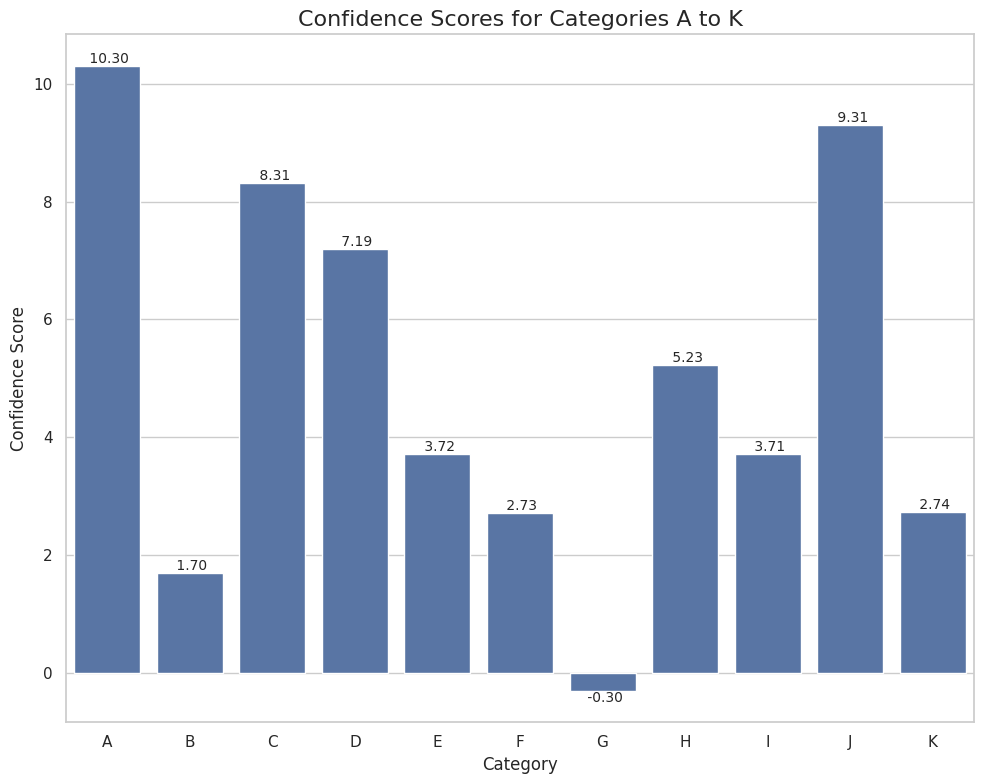

In [12]:
import MeCab
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix

# モデルと関連するオブジェクトの読み込み
svm_model = joblib.load('svm_model.joblib')
feature_dict = joblib.load('feature_dict.joblib')
le = joblib.load('label_encoder.joblib')

# MeCabの設定
tagger = MeCab.Tagger('-Owakati')

# テストケース
test_summary = "近年、大学には教育研究に加え、複雑化する社会課題の解決への貢献が期待されている。しかし、課題解決のための研究チームビルディングには問題点がある。既存のシーズから出発するフォアキャスティング法では必ずしも最適解が得られるとは限らない。また、社会課題起点のバックキャスティング法では人的リソースの制約から探索範囲が限られてしまう。そこで本研究では、機械学習技術を用いて社会課題と研究シーズを定量的に評価し、最適な研究チームメンバーを効率的に選び出す手法の開発を目的とする。具体的には、社会課題解決に必要な学術的要素を、複数の研究者のシーズの定量的な組み合わせで表す手法を確立する。この手法により、これまで属人的な資質に依存していたチームビルディングに、より客観的で再現性のある方法が提案可能となる。さらに、本研究は学術界だけでなく産業界や行政における人材マッチングにも応用でき、幅広い分野でのイノベーション創出に貢献することが期待される。"

# テキストの前処理
words = tagger.parse(test_summary).split()
words_set = " ".join(words)

# 特徴量ベクトルの作成
def create_sparse_feature_vector(summary):
    words = summary.split()
    row = []
    col = []
    data = []
    for word in words:
        if word in feature_dict:
            row.append(0)
            col.append(feature_dict[word])
            data.append(1)
    return csr_matrix((data, (row, col)), shape=(1, len(feature_dict)))

test_vector = create_sparse_feature_vector(words_set)

# モデルによる予測
predicted_category_index = svm_model.predict(test_vector)[0]
predicted_category = le.inverse_transform([predicted_category_index])[0]

print(f"\nテストベクトルの形状: {test_vector.shape}")
print(f"テストベクトルの非ゼロ要素数: {test_vector.nnz}")
print(f"予測されたカテゴリ: {predicted_category}")

# 確信度スコアの取得と表示
confidence_scores = svm_model.decision_function(test_vector)
print("\n各カテゴリの確信度スコア:")
for category, score in zip(le.classes_, confidence_scores[0]):
    print(f"{category}: {score:.4f}")

# グラフ表示用の設定
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# カテゴリとスコアのペアを作成（AからKまでの順）
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K']
scores = confidence_scores[0]

# 棒グラフの作成（縦向き）
sns.barplot(x=categories, y=scores)

plt.title('Confidence Scores for Categories A to K', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Confidence Score', fontsize=12)

# スコアの値を棒グラフに追加
for i, v in enumerate(scores):
    plt.text(i, v, f' {v:.2f}', ha='center', va='bottom' if v >= 0 else 'top', fontsize=10)

plt.tight_layout()
plt.show()
